In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd './drive/MyDrive/dawn_chorus'

/content/drive/MyDrive/dawn_chorus


In [4]:
df = pd.read_csv('pa_reps2022-07-19.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,63,64,65,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head(2)

,created_at,district,Representative,party,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,quoted_name,quoted_followers_count,quoted_friends_count,quoted_statuses_count,quoted_location,quoted_description,quoted_verified,retweet_status_id,retweet_text,retweet_created_at,retweet_source,retweet_favorite_count,retweet_retweet_count,retweet_user_id,retweet_screen_name,retweet_name,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,place_url,place_name,place_full_name,place_type,country,country_code,coords_coords,bbox_coords,status_url,name.x,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified
0,2022-07-18T23:57:58Z,PA-01,Brian Fitzpatrick,Republican,@repbrianfitz,"Now more than ever, it is critical that we pro...",Twitter for iPhone,185,NaN,NaN,NaN,False,False,4,1,NaN,NaN,NaN,NaN,riponadvance.com/stories/fitzpa…,https://t.co/omVag47bcj,https://riponadvance.com/stories/fitzpatricks-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,|,|||||||,https://twitter.com/RepBrianFitz/status/154918...,Rep. Brian Fitzpatrick 🇺🇸,"Bucks County, PA",A fiercely independent voice for my hometown o...,https://t.co/fDbVS71DZP,False,21431,355,680,3888,480,2017-01-03T15:20:39Z,True
1,2022-07-17T13:38:30Z,PA-01,Brian Fitzpatrick,Republican,@repbrianfitz,Thank you Dr. Umar Farooq and the Association ...,Twitter for iPhone,267,NaN,NaN,NaN,False,False,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/media/FX31LmpXoAEhxJt.jpg,https://t.co/k7ZPU2yTBx,https://twitter.com/RepBrianFitz/status/154866...,photo,http://pbs.twimg.com/media/FX31LmpXoAEhxJt.jpg,https://t.co/k7ZPU2yTBx,https://twitter.com/RepBrianFitz/status/154866...,NaN,826088894865297408,APPNA,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,|,|||||||,https://twitter.com/RepBrianFitz/status/154866...,Rep. Brian Fitzpatrick 🇺🇸,"Bucks County, PA",A fiercely independent voice for my hometown o...,https://t.co/fDbVS71DZP,False,21431,355,680,3888,480,2017-01-03T15:20:39Z,True


In [7]:
df.shape

(52312, 84)

In [ ]:
df.info()

#### Are all accounts verified?

In [9]:
df['verified'].unique()

array([ True])

In [10]:
# Is the data balanced

df['Representative'].value_counts()

Michael Doyle        3200
Susan Wild           3200
Mary Gay Scanlon     3199
Chrissy Houlahan     3199
Brian Fitzpatrick    3199
Dwight Evans         3199
Brendan Boyle        3198
Fred Keller          3196
Scott Perry          3195
Madeleine Dean       3194
Glenn Thompson       3194
Matt Cartwright      3192
Guy Reschenthaler    3191
Lloyd Smucker        3189
Mike Kelly           3172
Dan Mueser           1929
John Joyce           1700
Conor Lamb            766
Name: Representative, dtype: int64

Generally, yes, the data seems balanced, except we have very few tweets for Rep Lamb compared to others

### Let's narrow down the analysis to a few columns

In [11]:
df.columns

Index(['created_at', 'district', 'Representative', 'party', 'screen_name',
       'text', 'source', 'display_text_width', 'reply_to_status_id',
       'reply_to_user_id', 'reply_to_screen_name', 'is_quote', 'is_retweet',
       'favorite_count', 'retweet_count', 'quote_count', 'reply_count',
       'hashtags', 'symbols', 'urls_url', 'urls_t.co', 'urls_expanded_url',
       'media_url', 'media_t.co', 'media_expanded_url', 'media_type',
       'ext_media_url', 'ext_media_t.co', 'ext_media_expanded_url',
       'ext_media_type', 'mentions_user_id', 'mentions_screen_name', 'lang',
       'quoted_status_id', 'quoted_text', 'quoted_created_at', 'quoted_source',
       'quoted_favorite_count', 'quoted_retweet_count', 'quoted_user_id',
       'quoted_screen_name', 'quoted_name', 'quoted_followers_count',
       'quoted_friends_count', 'quoted_statuses_count', 'quoted_location',
       'quoted_description', 'quoted_verified', 'retweet_status_id',
       'retweet_text', 'retweet_created_at', 're

In [12]:
tweets_df = df[['district', 'Representative', 'party', 'text', 'followers_count']].copy(deep=True)

In [13]:
tweets_df.head()

,district,Representative,party,text,followers_count
0,PA-01,Brian Fitzpatrick,Republican,"Now more than ever, it is critical that we pro...",21431
1,PA-01,Brian Fitzpatrick,Republican,Thank you Dr. Umar Farooq and the Association ...,21431
2,PA-01,Brian Fitzpatrick,Republican,"Today marks the launch of 988, a new lifesavin...",21431
3,PA-01,Brian Fitzpatrick,Republican,I am proud to cosponsor this bipartisan legisl...,21431
4,PA-01,Brian Fitzpatrick,Republican,Joe was a recognized leader in Bristol and Buc...,21431


In [14]:
tweets_df['followers_count'].unique()

array([21431, 19839, 20859, 75065, 61056, 33681, 15940, 19591, 17356,
       40154, 12616, 15810, 15180, 25539, 23486, 26990, 22559, 23248])

In [15]:
representative = tweets_df['Representative'].unique().tolist()
len(representative)

18

We have tweets from all 18 congressional leaders in PA

In [16]:
followers = {}
for r in representative:
    followers[r] = tweets_df[tweets_df['Representative']==r]['followers_count'].max()

In [17]:
followers

{'Brendan Boyle': 19839,
 'Brian Fitzpatrick': 21431,
 'Chrissy Houlahan': 33681,
 'Conor Lamb': 22559,
 'Dan Mueser': 17356,
 'Dwight Evans': 20859,
 'Fred Keller': 15810,
 'Glenn Thompson': 23486,
 'Guy Reschenthaler': 25539,
 'John Joyce': 15180,
 'Lloyd Smucker': 12616,
 'Madeleine Dean': 75065,
 'Mary Gay Scanlon': 61056,
 'Matt Cartwright': 19591,
 'Michael Doyle': 23248,
 'Mike Kelly': 26990,
 'Scott Perry': 40154,
 'Susan Wild': 15940}

In [18]:
followers_df = pd.DataFrame.from_dict(followers, orient='index')
followers_df.sort_values(by=0, inplace=True)

In [19]:
sns.set_context('notebook')

<Figure size 1080x648 with 0 Axes>

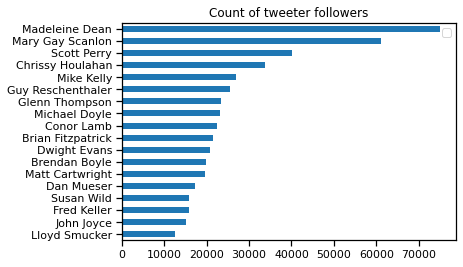

In [20]:
plt.figure(figsize=(15, 9))
followers_df.plot(kind='barh')
plt.legend('')
plt.xticks()
plt.title('Count of tweeter followers');

From the graph above, we can see that Madeleine Dean is the most popular congressional leader in PA. 

#### What is representation of political parties among the representatives 

In [21]:
tweets_df['party'].value_counts(normalize=True)

Democratic    0.503651
Republican    0.496349
Name: party, dtype: float64

#### Let's see which words are most represented in the entire corpus of tweets

First, we should clean up the tweets 

In [22]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    text = text.replace('amp', ' ')
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: remove_emojis(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
tweets_df['emoji_free_tweets'] = tweets_df['text'].apply(call_emoji_free)

#Create a new column with url free tweets
tweets_df['url_free_tweets'] = tweets_df['emoji_free_tweets'].apply(url_free_text)

In [23]:
# Keep only the clean version of texts 

tweets_df.drop(columns=['text', 'emoji_free_tweets'], inplace=True)

In [24]:
tweets_df.head()

,district,Representative,party,followers_count,url_free_tweets
0,PA-01,Brian Fitzpatrick,Republican,21431,"Now more than ever, it is critical that we pro..."
1,PA-01,Brian Fitzpatrick,Republican,21431,Thank you Dr. Umar Farooq and the Association ...
2,PA-01,Brian Fitzpatrick,Republican,21431,"Today marks the launch of 988, a new lifesavin..."
3,PA-01,Brian Fitzpatrick,Republican,21431,I am proud to cosponsor this bipartisan legisl...
4,PA-01,Brian Fitzpatrick,Republican,21431,Joe was a recognized leader in Bristol and Buc...


In [25]:
# Tokenize our tweets 

text = tweets_df['url_free_tweets'].copy(deep=True)

cv = CountVectorizer(stop_words='english', max_df=.90, min_df=2)
cv.fit(text)
text_cv = cv.transform(text)

In [26]:
text_df = pd.DataFrame(text_cv.A, columns=cv.get_feature_names_out())

#### What are the most common word in all tweets across the entire corpus?

In [27]:
text_df.sum().sort_values(ascending=False).head(10)

today        6729
act          4647
american     4092
people       3704
americans    3572
house        3512
help         3454
health       3304
work         3246
support      3218
dtype: int64

#### What are the least commonly used words in the entire corpus?

In [28]:
text_df.sum().sort_values(ascending=True).head(10)

únete                        2
childhoodcancerawareness     2
moses                        2
moshannon                    2
childhealthday               2
childcareisinfrastructure    2
motels                       2
childabusepreventionmonth    2
motherhood                   2
moscow                       2
dtype: int64

### Add vectorized text to the tweets dataframe

In [29]:
# How many tokens were created by the countvectorizer?
text_df.shape[1]

21971

In [30]:
tweets_cv = pd.concat([tweets_df, text_df], axis=1)

In [31]:
tweets_cv.head()

Output hidden; open in https://colab.research.google.com to view.

#### Let's look at the corpus by representative

In [32]:
representative

['Brian Fitzpatrick',
 'Brendan Boyle',
 'Dwight Evans',
 'Madeleine Dean',
 'Mary Gay Scanlon',
 'Chrissy Houlahan',
 'Susan Wild',
 'Matt Cartwright',
 'Dan Mueser',
 'Scott Perry',
 'Lloyd Smucker',
 'Fred Keller',
 'John Joyce',
 'Guy Reschenthaler',
 'Glenn Thompson',
 'Mike Kelly',
 'Conor Lamb',
 'Michael Doyle']

In [33]:
Fitzpatrick = tweets_cv.query('Representative == "Brian Fitzpatrick"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])

In [34]:
Boyle = tweets_cv.query('Representative == "Brendan Boyle"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Evans = tweets_cv.query('Representative == "Dwight Evans"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Dean = tweets_cv.query('Representative == "Madeleine Dean"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Scanlon = tweets_cv.query('Representative == "Mary Gay Scanlon"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Houlahan = tweets_cv.query('Representative == "Chrissy Houlahan"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Wild = tweets_cv.query('Representative == "Susan Wild"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])

In [35]:
Cartwright = tweets_cv.query('Representative == "Matt Cartwright"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Mueser = tweets_cv.query('Representative == "Dan Mueser"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Perry = tweets_cv.query('Representative == "Scott Perry"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Smucker = tweets_cv.query('Representative == "Lloyd Smucker"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Keller = tweets_cv.query('Representative == "Fred Keller"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Joyce = tweets_cv.query('Representative == "John Joyce"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Reschenthaler = tweets_cv.query('Representative == "Guy Reschenthaler"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Thompson = tweets_cv.query('Representative == "Glenn Thompson"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Kelly = tweets_cv.query('Representative == "Mike Kelly"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Lamb = tweets_cv.query('Representative == "Conor Lamb"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])
Doyle = tweets_cv.query('Representative == "Michael Doyle"').drop(columns=['district','party','followers_count', 'Representative', 'url_free_tweets'])

### Let's look at the most common words by representative for the first 7 representatives on our list above

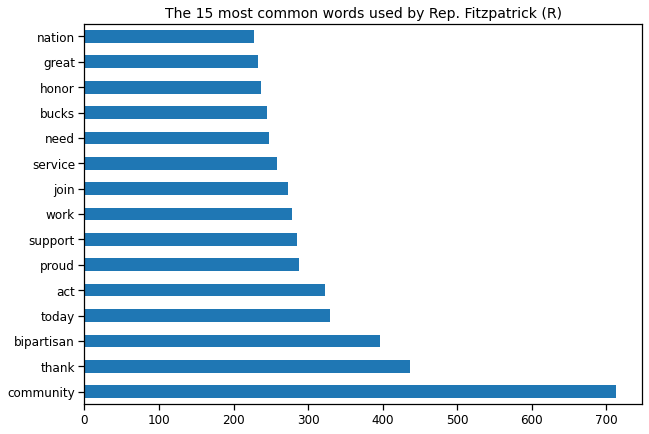

In [36]:
plt.figure(figsize=(10, 7))
Fitzpatrick.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Fitzpatrick (R)', fontsize=14);

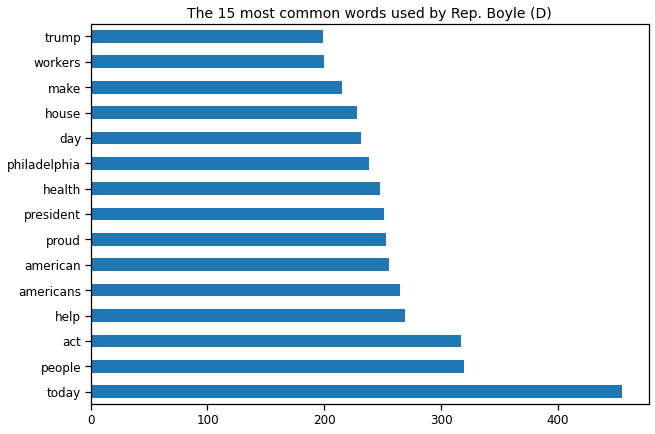

In [37]:
plt.figure(figsize=(10, 7))
Boyle.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Boyle (D)', fontsize=14);

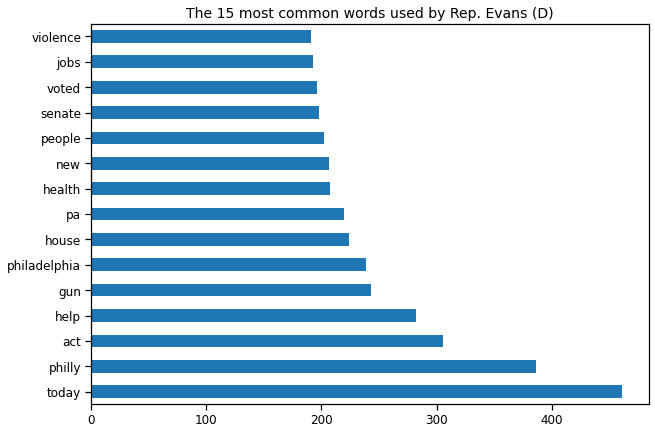

In [38]:
plt.figure(figsize=(10, 7))
Evans.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Evans (D)', fontsize=14);

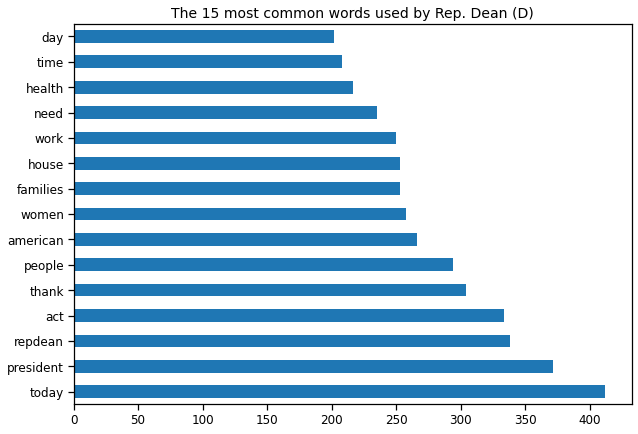

In [39]:
plt.figure(figsize=(10, 7))
Dean.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Dean (D)', fontsize=14);

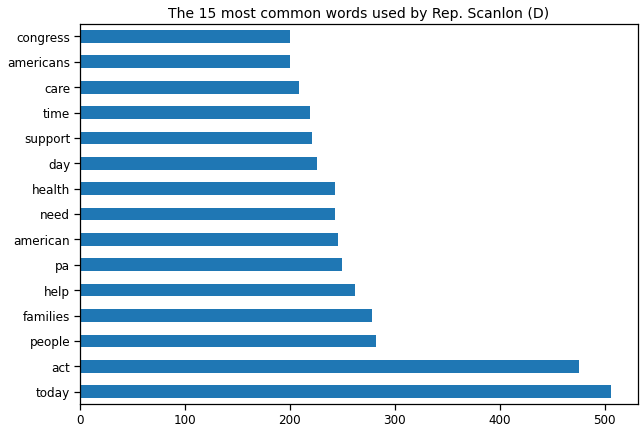

In [40]:
plt.figure(figsize=(10, 7))
Scanlon.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Scanlon (D)', fontsize=14);

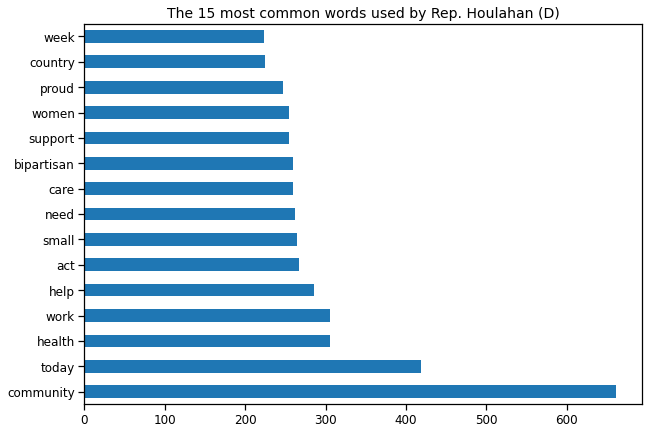

In [41]:
plt.figure(figsize=(10, 7))
Houlahan.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Houlahan (D)', fontsize=14);

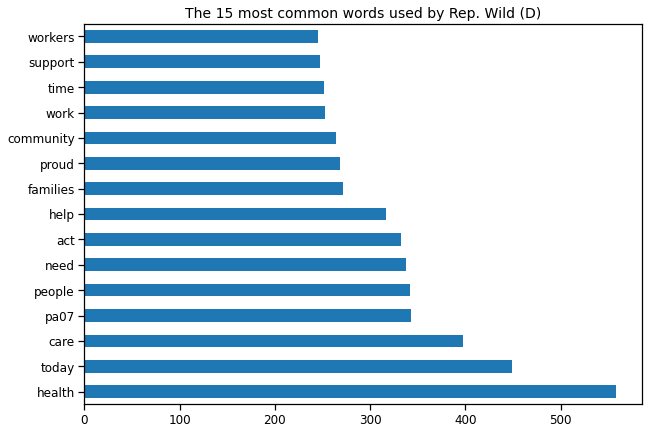

In [42]:
plt.figure(figsize=(10, 7))
Wild.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The 15 most common words used by Rep. Wild (D)', fontsize=14);

From the sample above, we can see a lot of overlap in the words that the PA representatives use on Twitter. Top of many lists include:


*   health
*   work/workers
*   help



